1D Hydrodynamics - Shock Tube Problem

Import Necessary Libraries

In [13]:
import math
import matplotlib.pyplot as plt

Define a staggered grid with scalar values and vector values defined every other index. The grid has a built in boundary condition for updating the system, where the scalar and vector quantities at the endpoints are set equal to that of their neighbors.

In [14]:
class Grid:
    def __init__(self, dx) -> None:
        self.scalars = []
        self.vectors = []
        self.dx = dx

    def boundary(self):
        self.scalars[0] = self.scalars[1]
        self.scalars[-1] = self.scalars[-2]

        self.vectors[0] = self.vectors[1]
        self.vectors[-1] = self.vectors[-2]

Calculate dt using CFL condition. The CFL (Courant-Friedrichs-Lewy) condition function calculates the maximum allowable time step size (dt) to ensure numerical stability by taking the minimum value from the ratios of the spatial grid size (dx) to the sum of the absolute velocity (v) and the sound speed (cs) across all cells.

In [15]:
cfl = 0.3
gamma = 1.4

def get_dt(grid):
    vals = []
    for i in range(len(grid.scalars)):
        P = grid.scalars[i][0]
        rho = grid.scalars[i][1]
        v = grid.vectors[i][0]
        dx = grid.dx

        if rho == 0:
            print('OMG', i)
            rho = max(rho, 1e-4)

        cs = math.sqrt(max(0, gamma * P/rho))
        vals.append(dx / (abs(v) + cs))

    dt = cfl * min(vals)
    return  max(dt, 1e-3)

Functions for the Source terms and Advection terms for solving the conservation of mass, conservation of energy, and conservation of momentum equations.

In [16]:
def source(grid, dt):
    new_scalars = []
    new_vectors = []
    for i in range(1, len(grid.scalars)-1):
        rho = grid.scalars[i][1]
        rho_prev = grid.scalars[i-1][1]
        e = grid.scalars[i][2]
        dx = grid.dx
        P_prev = grid.scalars[i-1][0]
        v = grid.vectors[i][0]
        v_next = grid.vectors[i+1][0]
        mom = grid.vectors[i][1]

 
        P = max((gamma - 1) * rho * e, 0)  # Prevent negative pressure


    
        e -= dt * (P * (v_next - v) / dx)  # Ensures correct dimensions and respects causality
        mom -= dt * (P - P_prev) / dx
        v = mom / max(0.5 * (rho + rho_prev), 1e-6)  # Avoid division by zero or small densities



        
        new_scalars.append([P, rho, e])
        new_vectors.append([v, mom])



    for i, (P, rho, e) in enumerate(new_scalars):
        if rho <= 0 or e < 0 or P < 0:
            print(f"Adjusting zero or negative values at index {i}: rho={rho}, e={e}")
            rho = max(rho, 1e-3)  # enforce a minimum positive density
            e = max(e, 1e-3)      # enforce a minimum positive energy
            P = max(P, 1e-3)
        new_scalars[i] = [P, rho, e]

    grid.scalars = [grid.scalars[0]] + new_scalars + [grid.scalars[-1]]
    grid.vectors = [grid.vectors[0]] + new_vectors + [grid.vectors[-1]]  

    grid.boundary()

    return

def advection(grid, dt):
    # Compute fluxes for each cell
    Fp = []  # Flux of density
    Fe = []  # Flux of energy
    Fm = []  # Flux of momentum

    for i in range(len(grid.scalars)):
        A = 1  # Cross-sectional area, assumed constant
        v = grid.vectors[i][0]  # Velocity at current cell
        # Determine density based on direction of velocity
        if v >= 0:
            rho = grid.scalars[i-1][1]
            eps = grid.scalars[i-1][2] / rho
        else:
            rho = grid.scalars[i][1]
            eps = grid.scalars[i][2] / rho

        Fp.append(A * rho * v)  # Calculate flux of density
        Fe.append(eps * A * rho * v)  # Calculate flux of energy

    # Calculate momentum flux using upwind scheme
    for i in range(len(grid.scalars)):
        
        if i != len(grid.scalars) - 1:
            avg_vi = 0.5 * (grid.vectors[i][0] + grid.vectors[i+1][0])

            if avg_vi >= 0:
                v = grid.vectors[i][0]
            else:
                v = grid.vectors[i+1][0]


            avg_Fp = 0.5 * (Fp[i] + Fp[i+1])
            Fmi = v * avg_Fp
        else:
            Fmi = grid.vectors[i][0] * Fp[i]  # Handle last cell boundary

        Fm.append(Fmi)

    # Update grid properties using computed fluxes
    new_scalars = []
    new_vectors = []
    for i in range(1, len(grid.scalars) - 1):
        rho = grid.scalars[i][1]
        e = grid.scalars[i][2]
        P = grid.scalars[i][0]
        mom = grid.vectors[i][1]
        dx = grid.dx

        # Update density and energy using flux differences
        rho -= (dt / dx) * (Fp[i+1] - Fp[i])
        e -= (dt / dx) * (Fe[i+1] - Fe[i])
        
        # Update momentum using flux differences
        mom -= (dt / dx) * (Fm[i] - Fm[i-1])
        v = mom / max(0.5 * (rho + grid.scalars[i-1][1]), 1e-6)  # Avoid division by small numbers

        new_scalars.append([P, max(rho, 1e-6), max(e, 1e-6)])  # Ensure non-negative density and energy
        new_vectors.append([v, mom])

    # Ensure boundary conditions are applied correctly
    grid.scalars = [grid.scalars[0]] + new_scalars + [grid.scalars[-1]]
    grid.vectors = [grid.vectors[0]] + new_vectors + [grid.vectors[-1]]
    grid.boundary()

    return

Plotting and Data Visualization

In [17]:
def full_plot(grid):
    x = [i for i in range(len(grid.scalars))]
    rhos = [grid.scalars[i][1] for i in range(len(grid.scalars))]
    Ps = [grid.scalars[i][0] for i in range(len(grid.scalars))]
    es = [grid.scalars[i][2] for i in range(len(grid.scalars))]
    vs = [grid.vectors[i][0] for i in range(len(grid.vectors))]
    plot(x, rhos, 'Density Profile', 'Cell Index', 'Density')
    plot(x, Ps, 'Pressure Profile', 'Cell Index', 'Pressure')
    plot(x, es, 'Energy Density Profile', 'Cell Index', 'Energy Density')
    plot(x, vs, 'Velocity Profile', 'Cell Index', 'Velocity')

def plot(x, y, title = 'hydro plot', x_axis='x', y_axis='y'):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.show()

Create update function and main function to run simulation and create plots

Initial:


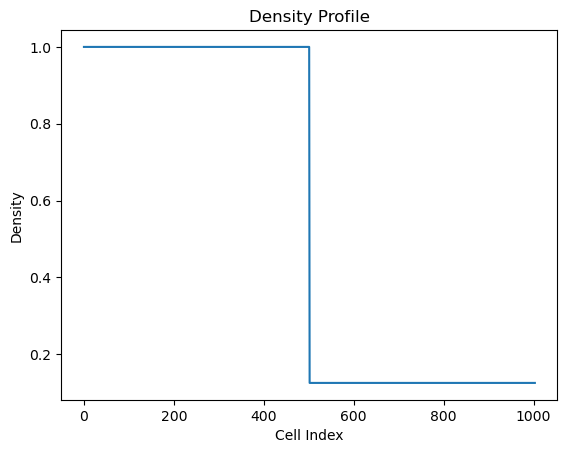

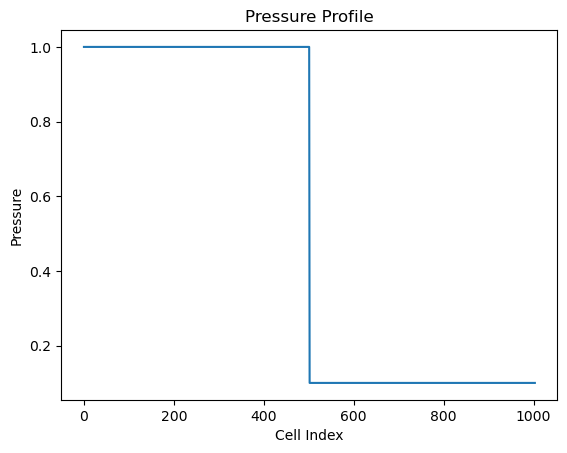

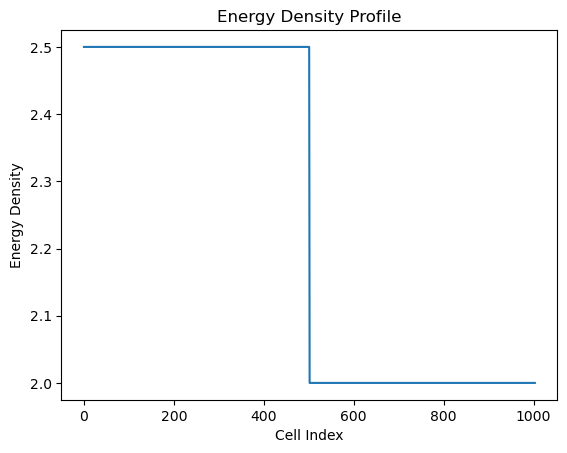

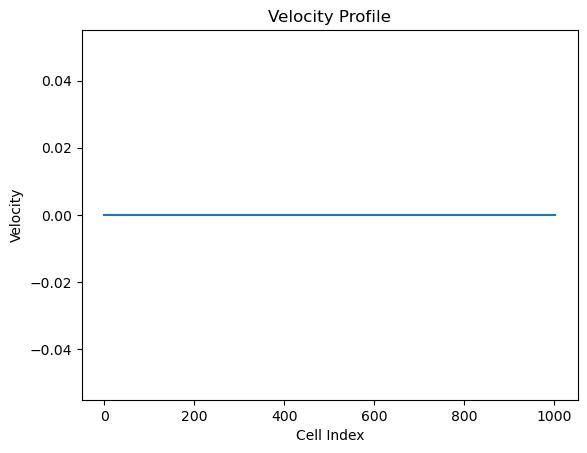

Final:


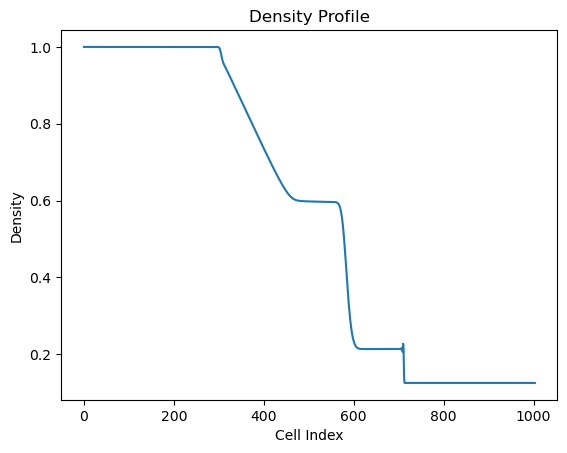

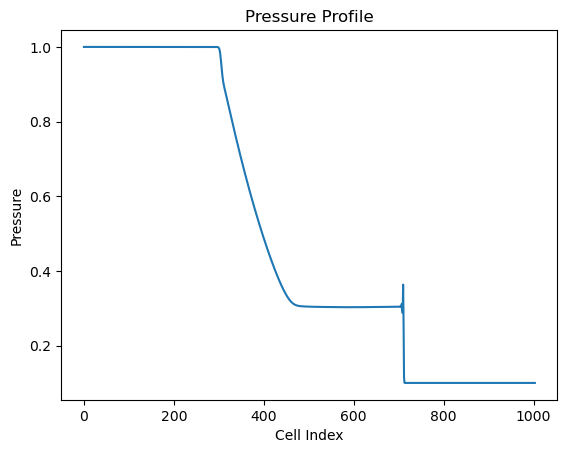

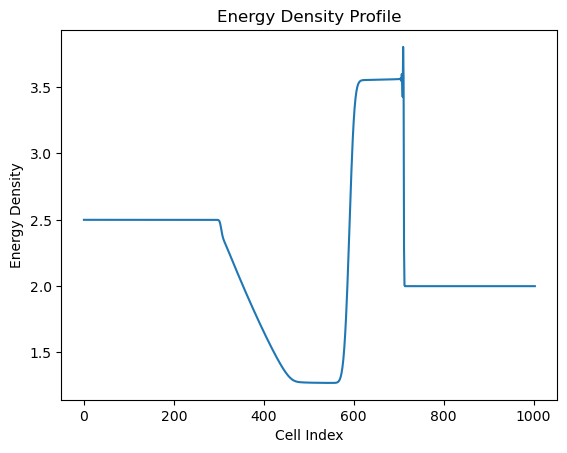

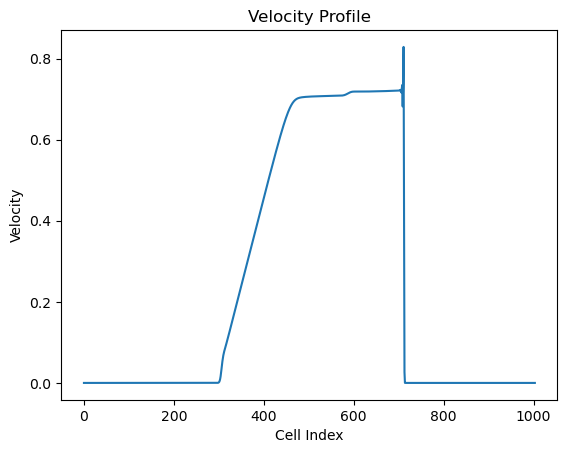

In [20]:
def update(grid, steps=10000):
    for i in range(steps):
        dt = get_dt(grid)
#         print(f"Step {i}, dt: {dt}")
        source(grid, dt)
        advection(grid, dt)
        # Optionally uncomment to monitor the state
        # print("Max and min values in scalars:", max(s[0] for s in grid.scalars), min(s[0] for s in grid.scalars))
#         if i % 100 == 0:  # Adjust the frequency of checks as needed
#             print(f"Step {i} summary:")
#             print("Pressure range:", min(s[0] for s in grid.scalars), max(s[0] for s in grid.scalars))
#             print("Density range:", min(s[1] for s in grid.scalars), max(s[1] for s in grid.scalars))
#             print("Energy range:", min(s[2] for s in grid.scalars), max(s[2] for s in grid.scalars))
    


def main():
    num_cells = 1004
    dx = 1
  


    grid = Grid(dx)

    i_half = (num_cells-4)/2 + 1

  
    for i in range(0, num_cells):
        if i <= i_half:
            P = 1
            rho = 1
        else:
            P = 0.1
            rho = 0.125
        
        e = (P/((gamma-1)*rho))
        grid.scalars.append([P, rho, round(e, 3), 0]) # (pressure, density, energy, time)
        grid.vectors.append([0, 0]) # velocity, momentum
    



    print('Initial:')
    full_plot(grid)

    update(grid, 900)
    
    print('Final:')
    full_plot(grid)



main()